In [1]:
import numpy as np
import imageio
import cv2
import matplotlib.pyplot
import imutils
from PIL import Image
import math

#from numba import jit

In [2]:
class NeuralNetwork:
    
    #initialise neural network
    def __init__(self, givenINodes, givenHNodes, givenONodes, givenLearningRate):
        print("Neural network init...")
        
        #setup number of nodes in each layer
        self.inputNodes = givenINodes
        self.hiddenNodes = givenHNodes
        self.outputNodes = givenONodes
        
        #setup weights with initial values
        self.weightsInputHidden = np.random.normal(0.0, pow(self.inputNodes, -0.5), (self.hiddenNodes, self.inputNodes))
        self.weightsHiddenOutput = np.random.normal(0.0, pow(self.hiddenNodes, -0.5), (self.outputNodes, self.hiddenNodes))
        
        #setup learning rate
        self.learningRate = givenLearningRate
        
        #setup activation function
        self.activationFunc = lambda x: self.sigmoid(x)
            
        pass
            
    def sigmoid(self, Z):
        A = 1 / (1 + np.exp(-Z))
        return A
    
    #train the neural network
    def train(self, givenInputs, givenTargets):
        
        #inputs and target lists turned into 2D arrays
        inputs = np.array(givenInputs, ndmin=2).T
        targets = np.array(givenTargets, ndmin=2).T
        
        #signals into hidden layer calculated
        hiddenInputs = np.dot(self.weightsInputHidden, inputs)
        #signals coming from hidden layer calculated
        hiddenOutputs = self.activationFunc(hiddenInputs)
        
        #signals into output layer calculated
        finalInputs = np.dot(self.weightsHiddenOutput, hiddenOutputs)
        #signals from output layer calculated
        finalOutputs = self.activationFunc(finalInputs)
        
        #error backpropagation:
        #errors from output layer
        outputErrors = targets - finalOutputs
        #errors from hidden layer
        hiddenErrors = np.dot(self.weightsHiddenOutput.T, outputErrors)
        
        #weight links updated between all layers
        self.weightsHiddenOutput += self.learningRate * np.dot((outputErrors * finalOutputs * (1.0 - finalOutputs)), np.transpose(hiddenOutputs))
        self.weightsInputHidden += self.learningRate * np.dot((hiddenErrors * hiddenOutputs * (1.0 - hiddenOutputs)), np.transpose(inputs))
        
        pass
    
    #query the neural network
    def query(self, givenInputs):
        #inputs list converted into a 2D array
        inputs = np.array(givenInputs, ndmin=2).T
        
        #signals into hidden layer calculated
        hiddenInputs = np.dot(self.weightsInputHidden, inputs)
        #signals coming from hidden layer calculated
        hiddenOutputs = self.activationFunc(hiddenInputs)
        
        #signals into output layer calculated
        finalInputs = np.dot(self.weightsHiddenOutput, hiddenOutputs)
        #final signals from neural net calculated
        finalOutputs = self.activationFunc(finalInputs)
        
        return finalOutputs
        

In [3]:
def setupNetwork(givenINodes, givenHNodes, givenONodes, givenLRate, givenSampleSize):
    
    #setup global vars and data structures
    global n
    global outputNodes
    global trainingDataList
    global trainingDataLabelsList
    global sampleSize
    
    sampleSize = givenSampleSize
    
    #set number of nodes in each layer
    inputNodes = givenINodes 
    hiddenNodes = givenHNodes
    outputNodes = givenONodes

    #set learning rate
    learningRate = givenLRate
    
    #an instance of the neural network created
    n = NeuralNetwork(inputNodes, hiddenNodes, outputNodes, learningRate)
    
    #trainPrep
    
    #open training data file in READ mode
    #trainingDataFile = open("mnist_dataset/mnist_train.csv",'r')
    trainingDataFile = open("dataset_pixels.csv",'r')
    #save all the lines from the file into a list
    trainingDataList = trainingDataFile.readlines()
    #close the file
    trainingDataFile.close()

    trainingDataLabelsFile = open("dataset_labels.txt",'r')
    #save all the lines from the file into a list
    #trainingDataLabelsList = trainingDataLabelsFile.readlines()
    trainingDataLabelsList = trainingDataLabelsFile.read().splitlines()
    #close the file
    trainingDataLabelsFile.close()
    
    
    #number of times training data used for training
    epochs = 10
    
    print("Neural network being trained " + str(epochs) + " times!")
    
    for e in range(epochs):
        print("Training epoch " + str(e))
        #for every record in the training data
        for record in trainingDataList:
            #split each record by the commas
            allVals = record.split(',')
            #scale and shift the inputs
            inputs = (np.asfarray(allVals) / 255.0 * 0.99) + 0.01

            #target output values created
            targets = np.zeros(outputNodes) + 0.01
            currentIndex = trainingDataList.index(record)
            #print(currentIndex)
            targets[(math.ceil(currentIndex/sampleSize))-1] = 0.99
            n.train(inputs, targets)

            pass
        pass

    pass

    print("Neural network set up.")

In [4]:
def makeSquare(imageName):
    #input image
    im = Image.open('separated/' + imageName)
    #make the image a square shape
    sqrWidth = np.ceil(np.sqrt(im.size[0]*im.size[1])).astype(int) 
    im_resize = im.resize((sqrWidth, sqrWidth)) 
    #save
    im_resize.save('output.png')
    pass

In [5]:
def identifyChar(imageName):
    
    print ("Loading image...")
    makeSquare(imageName)
    
    #read in square image
    imageArray = imageio.imread('output.png', as_gray=True)
    
    #rotate image
    imageRotated = imutils.rotate(imageArray, 360)
    
    #make image 45 by 45 pixels 
    imageResized = cv2.resize(imageRotated, (45, 45), cv2.INTER_AREA)
    
    #scale and shift image inputs
    imageData = 255.0 - imageResized.reshape(2025)
    imageData = (imageData / 255.0 * 0.99) + 0.01

    print ("Min:", np.min(imageData))
    print ("Max:", np.max(imageData))

    #display image
    matplotlib.pyplot.imshow(imageData.reshape(45,45), cmap='Greys', interpolation='None')
    
    #query the neural net
    outputs = n.query(imageData)

    #print (outputs)
    #print(sampleSize)

    labelIndex = np.argmax(outputs)
    
    label = trainingDataLabelsList[(labelIndex*sampleSize)+1]
    print ("Predicted value:", label)

    return label

In [ ]:
#neural.setupNetwork(2025, 550, 10, 0.70, 100)

Loading image...
Min: 0.01
Max: 0.6580155
[[2.08311768e-03]
 [4.90587150e-02]
 [9.45276189e-02]
 [7.23008425e-04]
 [6.72712731e-02]
 [2.83083694e-04]
 [3.04377048e-03]
 [9.27930602e-01]
 [8.75042566e-03]
 [8.20849037e-01]
 [8.57343784e-01]]
Predicted value: 5


'5'

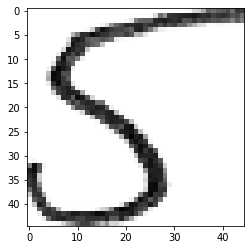

In [43]:
#identifyChar("roi0.png")